<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Task-description" data-toc-modified-id="Task-description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Task description</a></span></li><li><span><a href="#Dataset-visualization" data-toc-modified-id="Dataset-visualization-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dataset visualization</a></span></li><li><span><a href="#Generate-data-for-experiments" data-toc-modified-id="Generate-data-for-experiments-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Generate data for experiments</a></span></li><li><span><a href="#DR-RBF" data-toc-modified-id="DR-RBF-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>DR-RBF</a></span></li><li><span><a href="#DR-Matern" data-toc-modified-id="DR-Matern-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>DR-Matern</a></span></li><li><span><a href="#DR-GA" data-toc-modified-id="DR-GA-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>DR-GA</a></span></li><li><span><a href="#KES" data-toc-modified-id="KES-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>KES</a></span></li><li><span><a href="#SES" data-toc-modified-id="SES-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>SES</a></span></li><li><span><a href="#DeepSets" data-toc-modified-id="DeepSets-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>DeepSets</a></span><ul class="toc-item"><li><span><a href="#Results" data-toc-modified-id="Results-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>Results</a></span></li></ul></li></ul></div>

In [1]:
import sys
sys.path.append('../src')

import time
import numpy as np
import torch
import pandas as pd
import importlib
from tqdm import tqdm as tqdm
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

import utils_particles

import DR_RBF
import DR_GA
import DR_Matern
import KES
import SES
import sklearn_transformers
import deep_sets


import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pylab as pylab
ff = 20
params = {'legend.fontsize': ff,
          'figure.figsize': (16, 5),
          'axes.labelsize': ff,
          'axes.titlesize':ff,
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


# Task description

The goal is to infer the temperature $T$ of a simulated ideal gas from the trajectories traced by the $N$ particles that compose the gas. The particles evolve in a $3$-d box of fixed volume $V$. The training dataset corresponds to $M$ gases, and is in the form $\{(\{x^{i,j}\}_{j=1}^{N},T_i)\}_{i=1}^{M}$, where $T_i$ is the temperature (in Kelvin) of gas $i$, and $x^{i,j}$ is the $3$-d time-series corresponding to the particle $j$ of gas $i$. 

In this notebook we simulate $M=20$ gases subject to a temperature chosen at random $T\sim\mathcal{U}(1,1000)$. Each gas is composed by $N=20$ particles. We conduct too experiments: 
- **(low number of collisions)** the particles have a small radius $r=0.05\cdot(V/N)^{1/3}$. (precomputed dataset: ./data/low_col_particles.obj)
- **(high number of collisions)** the particles have a bigger radius $r=0.35\cdot(V/N)^{1/3}$. (precomputed dataset: ./data/high_col_particles.obj)

This notebook contains the code to generate new datasets. Alternatively, 2 precomputed datasets can be loaded.

# Dataset visualization 

In [2]:
# gas properties
n_particles = 20
V = 3
r = 3.5e-1*(V/n_particles)**(1./3)
max_time = 2
dt = 0.005

# chose the range of temperatures 
temps = [1, 500, 1000]

# simulate gases subject to the temperatures defined above
gases_plot = []
for temp in temps:
    
    Gas = utils_particles.Sim(n_particles, r, temp, V, max_time, dt)

    # To store the trajectories
    trajectories = [[] for i in range(n_particles)]

    for t in np.linspace(0, Gas.max_time, Gas.Nt):
        positions = Gas._draw_frame(t)
        for i in range(len(trajectories)):
            trajectories[i].append(list(positions[i]))
    trajectories = [np.array(particle) for particle in trajectories]

    gases_plot.append(trajectories)

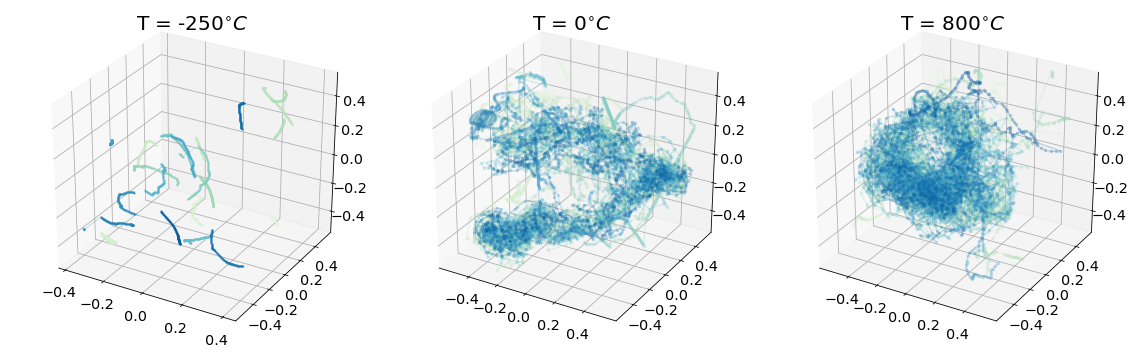

In [32]:
# plot
colors = plt.cm.GnBu(np.linspace(0.1,0.9,n_particles))
fig = plt.figure()

tt = [-250, 0, 800]

u = 0

for k in range(len(temps)):
    if u==0:
        ss = 1.
    else:
        ss = 2.5
    ax = fig.add_subplot(1, len(temps), k+1, projection='3d')
    for p in range(n_particles):
        ax.plot(gases_plot[k][p][:,0],gases_plot[k][p][:,1],gases_plot[k][p][:,2], alpha=0.2, color=colors[p], 
                marker='o', markersize=ss)
    temp_celsius = tt[k]#temps[k]-273
    ax.set_title(f'T = {temp_celsius}' + '$^{\circ}C$')
    u+=1
    
fig.tight_layout()
#plt.savefig('../pictures/ideal_gas.png')
plt.show()

# Generate data for experiments

**Properties of the gases**

In [2]:
# how many gases
np.random.seed(0)
M = 50

# parameters which do not change from one gas to another
n_particles = 20
V = 3
r = 3.5e-1*(V/n_particles)**(1./3)
max_time = 2
dt = 0.01


# temperatures of the M gases
max_T = 1000
min_T = 1
temperatures = np.array((max_T-min_T)*np.random.rand(M)+min_T)

**Simulate $M$ gases**

In [3]:
gases = []
for temp in tqdm(temperatures):
    
    Gas = utils_particles.Sim(n_particles, r, temp, V, max_time, dt)
    
    # To store the trajectories
    trajectories = [[] for i in range(n_particles)]

    for t in np.linspace(0, Gas.max_time, Gas.Nt):
        positions = Gas._draw_frame(t)
        for i in range(len(trajectories)):
            # update particle i
            trajectories[i].append(list(positions[i]))
    trajectories = [np.array(particle) for particle in trajectories]
    
    gases.append(trajectories)

100%|██████████| 50/50 [00:31<00:00,  1.60it/s]


# DR-RBF

In [4]:
m_mse, std_mse, results_RBF = DR_RBF.model(gases, temperatures/max_T, ll=[0,1,2], at=True, mode='krr', NUM_TRIALS=5,  cv=3)

100%|██████████| 5/5 [01:08<00:00, 13.72s/it]


# DR-Matern

In [5]:
m_mse, std_mse, results_Matern = DR_Matern.model(gases, temperatures/max_T, ll=[0,1,2], at=True, mode='krr', NUM_TRIALS=5,  cv=3)

100%|██████████| 5/5 [01:03<00:00, 12.70s/it]


# DR-GA

In [6]:
m_mse, std_mse, results_GA = DR_GA.model(gases, temperatures/max_T, ll=[0,1,2], at=True, mode='krr', lambdas=[0.01],NUM_TRIALS=5,  cv=3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 544 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1275 out of 1275 | elapsed:  1.6min finished


best lambda (cv on the train set):  0.01
best lambda (cv on the train set):  0.01
best lambda (cv on the train set):  0.01
best lambda (cv on the train set):  0.01
best lambda (cv on the train set):  0.01


# KES

In [7]:
m_mse, std_mse, results_KES = KES.model(gases, temperatures/max_T,ll=[0,1,2],at=True, scales = [0.4], mode='krr', NUM_TRIALS=5,  cv=3)

  0%|          | 0/1 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 544 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 1275 out of 1275 | elapsed:   50.0s finished
 20%|██        | 1/5 [00:02<00:11,  2.93s/it]

best scaling parameter (cv on the train set):  0.4


 60%|██████    | 3/5 [00:03<00:03,  1.54s/it]

best scaling parameter (cv on the train set):  0.4
best scaling parameter (cv on the train set):  0.4


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]

best scaling parameter (cv on the train set):  0.4
best scaling parameter (cv on the train set):  0.4


# SES

In [8]:
m_mse, std_mse, results_SES  = SES.model(gases, temperatures/max_T, ll=[0,1,2],at=True, depths1=[2,3], depth2=2,NUM_TRIALS=5, cv=3)

 20%|██        | 1/5 [00:31<02:05, 31.42s/it]

best truncation level (cv on train set):  3


 40%|████      | 2/5 [01:05<01:36, 32.17s/it]

best truncation level (cv on train set):  2


 60%|██████    | 3/5 [01:36<01:03, 31.73s/it]

best truncation level (cv on train set):  3


 80%|████████  | 4/5 [02:10<00:32, 32.55s/it]

best truncation level (cv on train set):  2


100%|██████████| 5/5 [02:44<00:00, 32.88s/it]

best truncation level (cv on train set):  3


# DeepSets

In [9]:
batch_size = 20
nb_epoch = 500
importlib.reload(deep_sets)
X = gases.copy()
y = temperatures/max_T
ll=[0,1,2]
at = True

from sklearn_transformers import AddTime, LeadLag
if ll is not None:
    X = LeadLag(ll).fit_transform(X)
if at:
    X = AddTime().fit_transform(X)

In [11]:
MSEs = []
results_deepsets = [] 

start = time.time()

for j in range(5):
    
    X_train, X_test, y_train, y_test = train_test_split([[x.reshape(-1) for x in xx] for xx in X], y, test_size=0.2, random_state=j)
    np.random.seed(0)
    # augment data
    
    X_train_aug = X_train
    y_train_aug = y_train
    
    X_train_aug = []
    y_train_aug = []
    for k,bag in enumerate(X_train):
        for i in range(30):
            X_train_aug.append(np.array(bag)+np.random.rand())
            y_train_aug.append(y_train[k]+1e-7*np.random.rand())

    
    train = deep_sets.DataIterator(torch.Tensor(X_train), torch.Tensor(y_train), batch_size, shuffle=True)
    test  = deep_sets.DataIterator(torch.Tensor(X_test), torch.Tensor(y_test), 1)

    model = deep_sets.DeepSet
    
    t = deep_sets.Trainer(train.d, model, nb_epoch)

    t.fit(train,test)
    
    res = t.evaluate(test)
    MSEs.append(res)
    
    res_full = t.evaluate(test,return_all=True)
    results_deepsets.append(res_full)

end = time.time()

print('time', end-start)
print(np.mean(MSEs), np.std(MSEs))

for i in range(len(results_deepsets)):
    results_deepsets[i]['pred']=np.array([e.cpu().numpy()[0][0] for e in results_deepsets[i]['pred']])
    results_deepsets[i]['true']=np.array([e.cpu().numpy()[0] for e in results_deepsets[i]['true']])


## Results

In [12]:
from utils import mape as mape
from utils import mse as mse

In [14]:
print('DR-RBF', mape(results_RBF))
print('DR-Matern', mape(results_Matern))
print('DR-GA',mape(results_GA))
print('KES',mape(results_KES))
print('SES',mape(results_SES))
print('DeepSets',mape(results_deepsets))

In [16]:
print('DR-RBF', mse(results_RBF))
print('DR-Matern', mse(results_Matern))
print('DR-GA',mse(results_GA))
print('KES',mse(results_KES))
print('SES',mse(results_SES))
print('DeepSets',mse(results_deepsets))

**save results**

In [26]:
import pickle
results = {'rbf':results_RBF, 'Matern':results_Matern, 'GA':results_GA, 'KER':results_KES, 'SES':results_SES}
pickle.dump(results,open('particles_3.5_50.obj','wb'))